# Setup

In [77]:
import pandas as pd 
import numpy as np
import pickle 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras 
import tensorflow.python.platform.build_info as build
from database_connection import DBConn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

In [2]:
# check GPU availability 
print(f"TF is cuda build: {build.build_info['is_cuda_build']}")
print(f"Device list: {tf.config.list_physical_devices('GPU')}")

TF is cuda build: True
Device list: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# globals 
TABLE = 'even_shot_data_table'
FEATURES = ['event_distance', 'event_angle', 'seconds_elapsed', 'game_period', 'x', 'y', 
            'is_home', 'score_down_4', 'score_down_3', 'score_down_2', 'score_down_1', 
            'score_up_4', 'score_up_3', 'score_up_2', 'score_up_1', 'score_even', 'wrist_shot', 
            'deflected_shot', 'tip_shot', 'slap_shot', 'backhand_shot', 'snap_shot', 
            'wrap_shot', 'state_5v5', 'state_4v4', 'state_3v3', 'goal']

# database connection 
db = DBConn()

In [4]:
# load the data in and check out a sample 
raw_df = db.query_with_copy(f'SELECT * FROM {TABLE}')
raw_df.head() 

,id,game_id,season,game_date,game_period,shot_event,seconds_elapsed,strength,strength_2,event_team,...,state_5v4,state_4v3,state_5v3,state_6v5,state_6v4,state_4v5,state_3v4,state_3v5,is_forward,off_wing
0,524157,2010020961,20102011,2011-03-03,2,SHOT,53,5x5,EV,BUF,...,0,0,0,0,0,0,0,0,1,0
1,524177,2010020961,20102011,2011-03-03,2,GOAL,612,5x5,EV,BUF,...,0,0,0,0,0,0,0,0,1,1
2,524179,2010020961,20102011,2011-03-03,2,MISS,702,5x5,EV,BUF,...,0,0,0,0,0,0,0,0,0,0
3,524260,2010020962,20102011,2011-03-03,1,MISS,496,5x5,EV,OTT,...,0,0,0,0,0,0,0,0,1,1
4,524285,2010020962,20102011,2011-03-03,1,SHOT,1160,5x5,EV,ATL,...,0,0,0,0,0,0,0,0,0,1


# Initial Exploration

In [5]:
raw_df.shape

(1273536, 83)

In [6]:
# check label distribution 
raw_df['goal'].value_counts()

goal
0    1196125
1      77411
Name: count, dtype: int64

In [7]:
# check that the shot_event and goal columns line up 
raw_df[raw_df['shot_event'] == 'GOAL'].shape

(77411, 83)

In [8]:
# check shot_event distribution 
raw_df['shot_event'].value_counts()

shot_event
SHOT    841932
MISS    354193
GOAL     77411
Name: count, dtype: int64

In [9]:
# look at null values 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(raw_df.isnull().sum())

id                       0
game_id                  0
season                   0
game_date                0
game_period              0
shot_event               0
seconds_elapsed          0
strength                 0
strength_2           30222
event_team               0
away_team                0
home_team                0
position                 0
shoots                   0
player1                  0
player2            1201377
player3            1216547
away_player1          4297
away_player2          6024
away_player3          5684
away_player4          6992
away_player5         13323
away_player6         48510
home_player1          4308
home_player2          5369
home_player3          6018
home_player4          7119
home_player5         13022
home_player6         47865
away_players             0
home_players             0
away_score               0
home_score               0
away_goalie          20004
home_goalie          18847
home_coach               0
away_coach               0
e

In [10]:
# make sure only even strength data is present  
raw_df['strength'].value_counts()

strength
5x5    1229507
4x4      35153
3x3       8876
Name: count, dtype: int64

# Isolate Relevant Data

In [11]:
df = raw_df[FEATURES]
df.sample(10)

,event_distance,event_angle,seconds_elapsed,game_period,x,y,is_home,score_down_4,score_down_3,score_down_2,...,deflected_shot,tip_shot,slap_shot,backhand_shot,snap_shot,wrap_shot,state_5v5,state_4v4,state_3v3,goal
705909,19.104973,42.878904,1092,1,75,-13,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
523241,8.544004,20.556045,514,1,81,-3,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
735729,10.770330,21.801409,23,2,79,4,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
969182,71.386273,11.309932,343,3,19,-14,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1226601,40.224371,55.124672,605,2,66,33,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
946841,42.449971,43.090848,1082,2,58,29,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
312390,36.000000,0.000000,901,1,53,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
115019,30.232433,55.784298,154,3,72,-25,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
941449,40.261644,14.381395,703,3,50,-10,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
549803,54.424259,20.432829,29,3,38,-19,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [12]:
df.isnull().sum()

event_distance     0
event_angle        0
seconds_elapsed    0
game_period        0
x                  0
y                  0
is_home            0
score_down_4       0
score_down_3       0
score_down_2       0
score_down_1       0
score_up_4         0
score_up_3         0
score_up_2         0
score_up_1         0
score_even         0
wrist_shot         0
deflected_shot     0
tip_shot           0
slap_shot          0
backhand_shot      0
snap_shot          0
wrap_shot          0
state_5v5          0
state_4v4          0
state_3v3          0
goal               0
dtype: int64

In [13]:
# check for outliers 
df.describe()

,event_distance,event_angle,seconds_elapsed,game_period,x,y,is_home,score_down_4,score_down_3,score_down_2,...,deflected_shot,tip_shot,slap_shot,backhand_shot,snap_shot,wrap_shot,state_5v5,state_4v4,state_3v3,goal
count,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,...,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06,1.273536e+06
mean,3.630366e+01,3.060605e+01,5.875719e+02,2.038210e+00,5.830303e+01,-1.502007e-01,5.123208e-01,2.116469e-02,3.738175e-02,9.004221e-02,...,2.013449e-02,5.798972e-02,1.818472e-01,7.987839e-02,1.399662e-01,1.152304e-02,9.654278e-01,2.760267e-02,6.969571e-03,6.078430e-02
std,2.220291e+01,2.022701e+01,3.495740e+02,8.544822e-01,2.227445e+01,1.929888e+01,4.998484e-01,1.439332e-01,1.896955e-01,2.862423e-01,...,1.404603e-01,2.337241e-01,3.857187e-01,2.711049e-01,3.469521e-01,1.067252e-01,1.826938e-01,1.638316e-01,8.319256e-02,2.389343e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-9.900000e+01,-4.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.868154e+01,1.552411e+01,2.780000e+02,1.000000e+00,4.400000e+01,-1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.440930e+01,2.823745e+01,5.760000e+02,2.000000e+00,6.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.024938e+01,4.227369e+01,8.910000e+02,3.000000e+00,7.600000e+01,1.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.926344e+02,9.000000e+01,1.200000e+03,8.000000e+00,9.900000e+01,4.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [14]:
# drop shots that occured from further than the red line
df = df[df['x'] >= 0]
df.shape

(1246028, 27)

In [15]:
# re-check data characteristics
df.describe()

,event_distance,event_angle,seconds_elapsed,game_period,x,y,is_home,score_down_4,score_down_3,score_down_2,...,deflected_shot,tip_shot,slap_shot,backhand_shot,snap_shot,wrap_shot,state_5v5,state_4v4,state_3v3,goal
count,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,...,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06
mean,3.443428e+01,3.078886e+01,5.866330e+02,2.036551e+00,6.024249e+01,-1.296102e-01,5.124387e-01,2.119455e-02,3.745421e-02,9.026282e-02,...,2.020500e-02,5.848344e-02,1.804285e-01,8.051424e-02,1.412866e-01,1.170279e-02,9.650489e-01,2.789263e-02,7.058429e-03,6.095048e-02
std,1.812320e+01,2.021274e+01,3.486540e+02,8.542607e-01,1.785242e+01,1.919506e+01,4.998455e-01,1.440325e-01,1.898721e-01,2.865580e-01,...,1.407010e-01,2.346554e-01,3.845441e-01,2.720878e-01,3.483170e-01,1.075446e-01,1.836560e-01,1.646653e-01,8.371746e-02,2.392395e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.838478e+01,1.575117e+01,2.780000e+02,1.000000e+00,4.600000e+01,-1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.373426e+01,2.844293e+01,5.760000e+02,2.000000e+00,6.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.909175e+01,4.251045e+01,8.880000e+02,3.000000e+00,7.600000e+01,1.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.841240e+01,9.000000e+01,1.200000e+03,8.000000e+00,9.900000e+01,4.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [16]:
df['goal'].value_counts()

goal
0    1170082
1      75946
Name: count, dtype: int64

# Visualize Data Characteristics

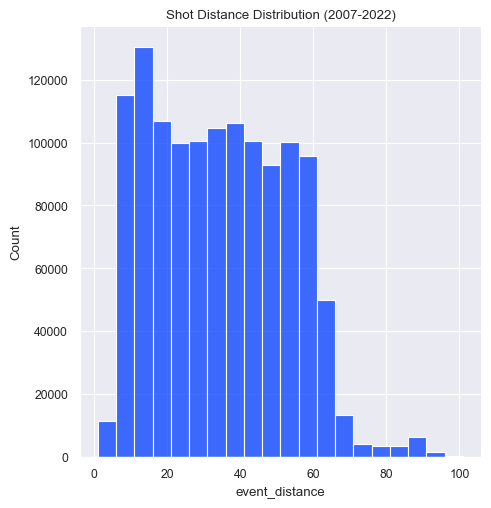

In [17]:
# full data shot distribution 
sns.set_theme(context = 'paper', style = 'darkgrid', palette = 'bright')
sns.displot(df, x = 'event_distance', binwidth = 5).set(title = 'Shot Distance Distribution (2007-2022)')

# Dataset Preparation

In [18]:
''' Not used for now. 

# using column transformer to only scale the non-binary features
ct = ColumnTransformer([
    ('ZeroToOneScaler', MinMaxScaler(), ['event_distance', 'event_angle', 'seconds_elapsed', 'x']),
    ('NegOneToOne', MinMaxScaler(feature_range = (-1, 1)), ['y'])
    ], remainder = 'passthrough'
)

# for the non random forest models 
df_scaled = ct.fit_transform(df)
df_scaled

'''

" Not used for now. \n\n# using column transformer to only scale the non-binary features\nct = ColumnTransformer([\n    ('ZeroToOneScaler', MinMaxScaler(), ['event_distance', 'event_angle', 'seconds_elapsed', 'x']),\n    ('NegOneToOne', MinMaxScaler(feature_range = (-1, 1)), ['y'])\n    ], remainder = 'passthrough'\n)\n\n# for the non random forest models \ndf_scaled = ct.fit_transform(df)\ndf_scaled\n\n"

In [19]:
# get x values 
x = df.drop('goal', axis = 1)
# get labels 
y = df['goal']

# split into train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 8, stratify = y)

In [20]:
print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

x_train shape: (996822, 26)
x_test shape: (249206, 26)
y_train shape: (996822,)
y_test shape: (249206,)


**Splits:**  
x_train shape: (996822, 26)  
x_test shape: (249206, 26)  
y_train shape: (996822,)  
y_test shape: (249206,)

# Logistic Regression

In [25]:
# parameter search space 
c = [x for x in np.logspace(-5, 3, 100)]
max_iter = [500, 1000, 2000, 4000]

lg_param_grid = [
    {'C': c,
     'max_iter': max_iter}
]

In [76]:
lg = LogisticRegression(class_weight = 'balanced') 
lg_search = RandomizedSearchCV(estimator = lg, param_distributions = lg_param_grid, scoring = ['f1', 'accuracy'], refit = 'f1', verbose = 3, n_iter = 50, cv = 5, error_score = 'raise')
lg_search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END C=0.0038535285937105314, max_iter=1000; accuracy: (test=0.654) f1: (test=0.202) total time=  34.6s
[CV 2/5] END C=0.0038535285937105314, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=   4.0s
[CV 3/5] END C=0.0038535285937105314, max_iter=1000; accuracy: (test=0.653) f1: (test=0.202) total time=  16.9s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.0038535285937105314, max_iter=1000; accuracy: (test=0.655) f1: (test=0.204) total time=  40.5s
[CV 5/5] END C=0.0038535285937105314, max_iter=1000; accuracy: (test=0.655) f1: (test=0.201) total time=   9.0s
[CV 1/5] END C=9.326033468832199e-05, max_iter=2000; accuracy: (test=0.652) f1: (test=0.202) total time=  21.3s
[CV 2/5] END C=9.326033468832199e-05, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=  10.5s
[CV 3/5] END C=9.326033468832199e-05, max_iter=2000; accuracy: (test=0.653) f1: (test=0.200) total time=   4.6s
[CV 4/5] END C=9.326033468832199e-05, max_iter=2000; accuracy: (test=0.656) f1: (test=0.203) total time=   5.4s
[CV 5/5] END C=9.326033468832199e-05, max_iter=2000; accuracy: (test=0.654) f1: (test=0.200) total time=   3.8s
[CV 1/5] END C=0.014174741629268062, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=   6.1s
[CV 2/5] END C=0.014174741629268062, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=  

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.0012618568830660211, max_iter=1000; accuracy: (test=0.651) f1: (test=0.202) total time=  39.1s
[CV 4/5] END C=0.0012618568830660211, max_iter=1000; accuracy: (test=0.656) f1: (test=0.204) total time=  21.9s
[CV 5/5] END C=0.0012618568830660211, max_iter=1000; accuracy: (test=0.654) f1: (test=0.201) total time=  19.5s
[CV 1/5] END C=0.0002848035868435802, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   8.5s
[CV 2/5] END C=0.0002848035868435802, max_iter=2000; accuracy: (test=0.654) f1: (test=0.202) total time=   4.0s
[CV 3/5] END C=0.0002848035868435802, max_iter=2000; accuracy: (test=0.653) f1: (test=0.201) total time=   4.0s
[CV 4/5] END C=0.0002848035868435802, max_iter=2000; accuracy: (test=0.656) f1: (test=0.203) total time=   6.4s
[CV 5/5] END C=0.0002848035868435802, max_iter=2000; accuracy: (test=0.639) f1: (test=0.197) total time=  50.7s
[CV 1/5] END C=572.236765935022, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   8.

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=155.56761439304753, max_iter=2000; accuracy: (test=0.641) f1: (test=0.199) total time= 1.3min
[CV 4/5] END C=155.56761439304753, max_iter=2000; accuracy: (test=0.656) f1: (test=0.204) total time=  28.7s
[CV 5/5] END C=155.56761439304753, max_iter=2000; accuracy: (test=0.655) f1: (test=0.201) total time=  19.0s
[CV 1/5] END C=0.8497534359086456, max_iter=2000; accuracy: (test=0.647) f1: (test=0.201) total time=  59.1s
[CV 2/5] END C=0.8497534359086456, max_iter=2000; accuracy: (test=0.654) f1: (test=0.202) total time=  20.1s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.8497534359086456, max_iter=2000; accuracy: (test=0.642) f1: (test=0.200) total time= 1.3min
[CV 4/5] END C=0.8497534359086456, max_iter=2000; accuracy: (test=0.650) f1: (test=0.203) total time=  50.9s
[CV 5/5] END C=0.8497534359086456, max_iter=2000; accuracy: (test=0.648) f1: (test=0.200) total time=  57.8s
[CV 1/5] END C=0.0015199110829529348, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=   4.4s
[CV 2/5] END C=0.0015199110829529348, max_iter=1000; accuracy: (test=0.654) f1: (test=0.202) total time=  16.7s
[CV 3/5] END C=0.0015199110829529348, max_iter=1000; accuracy: (test=0.653) f1: (test=0.202) total time=  14.3s
[CV 4/5] END C=0.0015199110829529348, max_iter=1000; accuracy: (test=0.656) f1: (test=0.203) total time=   3.6s
[CV 5/5] END C=0.0015199110829529348, max_iter=1000; accuracy: (test=0.655) f1: (test=0.201) total time=  13.0s
[CV 1/5] END C=0.024770763559917114, max_iter=2000; accuracy: (test=0.656) f1: (test=0.202) total time=  19.8s
[C

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=3.7649358067924714, max_iter=2000; accuracy: (test=0.646) f1: (test=0.202) total time= 1.3min
[CV 5/5] END C=3.7649358067924714, max_iter=2000; accuracy: (test=0.650) f1: (test=0.200) total time=  42.4s
[CV 1/5] END C=0.2782559402207126, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=  16.7s
[CV 2/5] END C=0.2782559402207126, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=   6.3s
[CV 3/5] END C=0.2782559402207126, max_iter=500; accuracy: (test=0.653) f1: (test=0.202) total time=   6.5s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.2782559402207126, max_iter=500; accuracy: (test=0.656) f1: (test=0.204) total time=  19.5s
[CV 5/5] END C=0.2782559402207126, max_iter=500; accuracy: (test=0.655) f1: (test=0.201) total time=  12.9s
[CV 1/5] END C=0.0012618568830660211, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   8.8s
[CV 2/5] END C=0.0012618568830660211, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   6.4s
[CV 3/5] END C=0.0012618568830660211, max_iter=2000; accuracy: (test=0.649) f1: (test=0.201) total time=  53.8s
[CV 4/5] END C=0.0012618568830660211, max_iter=2000; accuracy: (test=0.656) f1: (test=0.204) total time=  22.2s
[CV 5/5] END C=0.0012618568830660211, max_iter=2000; accuracy: (test=0.654) f1: (test=0.201) total time=  20.1s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=4.534878508128592, max_iter=2000; accuracy: (test=0.645) f1: (test=0.200) total time= 1.3min


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=4.534878508128592, max_iter=2000; accuracy: (test=0.646) f1: (test=0.201) total time= 1.3min
[CV 3/5] END C=4.534878508128592, max_iter=2000; accuracy: (test=0.653) f1: (test=0.202) total time=   5.4s
[CV 4/5] END C=4.534878508128592, max_iter=2000; accuracy: (test=0.653) f1: (test=0.203) total time=  34.7s
[CV 5/5] END C=4.534878508128592, max_iter=2000; accuracy: (test=0.654) f1: (test=0.201) total time=   2.7s
[CV 1/5] END C=3.678379771828634e-05, max_iter=2000; accuracy: (test=0.656) f1: (test=0.202) total time=   3.4s
[CV 2/5] END C=3.678379771828634e-05, max_iter=2000; accuracy: (test=0.656) f1: (test=0.201) total time=   3.4s
[CV 3/5] END C=3.678379771828634e-05, max_iter=2000; accuracy: (test=0.653) f1: (test=0.200) total time=   2.8s
[CV 4/5] END C=3.678379771828634e-05, max_iter=2000; accuracy: (test=0.656) f1: (test=0.201) total time=   3.9s
[CV 5/5] END C=3.678379771828634e-05, max_iter=2000; accuracy: (test=0.654) f1: (test=0.199) total time=   2.6s
[CV 1/5]

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=0.13219411484660315, max_iter=1000; accuracy: (test=0.653) f1: (test=0.203) total time=  39.4s
[CV 2/5] END C=0.13219411484660315, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=  21.3s
[CV 3/5] END C=0.13219411484660315, max_iter=1000; accuracy: (test=0.653) f1: (test=0.202) total time=   4.7s
[CV 4/5] END C=0.13219411484660315, max_iter=1000; accuracy: (test=0.655) f1: (test=0.204) total time=  33.8s
[CV 5/5] END C=0.13219411484660315, max_iter=1000; accuracy: (test=0.655) f1: (test=0.201) total time=   5.2s
[CV 1/5] END C=6.428073117284319e-05, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   4.7s
[CV 2/5] END C=6.428073117284319e-05, max_iter=2000; accuracy: (test=0.655) f1: (test=0.201) total time=   7.3s
[CV 3/5] END C=6.428073117284319e-05, max_iter=2000; accuracy: (test=0.653) f1: (test=0.200) total time=   5.8s
[CV 4/5] END C=6.428073117284319e-05, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   2.9s
[C

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=6.5793322465756825, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=  19.0s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=6.5793322465756825, max_iter=500; accuracy: (test=0.653) f1: (test=0.202) total time=  19.2s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=6.5793322465756825, max_iter=500; accuracy: (test=0.656) f1: (test=0.204) total time=  19.6s
[CV 5/5] END C=6.5793322465756825, max_iter=500; accuracy: (test=0.655) f1: (test=0.201) total time=  16.6s
[CV 1/5] END C=16.68100537200059, max_iter=4000; accuracy: (test=0.655) f1: (test=0.202) total time=  23.2s
[CV 2/5] END C=16.68100537200059, max_iter=4000; accuracy: (test=0.653) f1: (test=0.202) total time=  28.1s
[CV 3/5] END C=16.68100537200059, max_iter=4000; accuracy: (test=0.653) f1: (test=0.202) total time=  18.1s
[CV 4/5] END C=16.68100537200059, max_iter=4000; accuracy: (test=0.656) f1: (test=0.204) total time=  34.1s
[CV 5/5] END C=16.68100537200059, max_iter=4000; accuracy: (test=0.655) f1: (test=0.201) total time=   7.6s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1.2328467394420684, max_iter=500; accuracy: (test=0.654) f1: (test=0.202) total time=  19.6s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1.2328467394420684, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=  19.0s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2328467394420684, max_iter=500; accuracy: (test=0.653) f1: (test=0.202) total time=  19.1s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1.2328467394420684, max_iter=500; accuracy: (test=0.656) f1: (test=0.203) total time=  19.1s
[CV 5/5] END C=1.2328467394420684, max_iter=500; accuracy: (test=0.655) f1: (test=0.201) total time=   6.4s
[CV 1/5] END C=1.0235310218990268, max_iter=4000; accuracy: (test=0.655) f1: (test=0.202) total time=  20.9s
[CV 2/5] END C=1.0235310218990268, max_iter=4000; accuracy: (test=0.655) f1: (test=0.202) total time=  15.8s
[CV 3/5] END C=1.0235310218990268, max_iter=4000; accuracy: (test=0.653) f1: (test=0.202) total time=  17.6s
[CV 4/5] END C=1.0235310218990268, max_iter=4000; accuracy: (test=0.655) f1: (test=0.203) total time=  25.2s
[CV 5/5] END C=1.0235310218990268, max_iter=4000; accuracy: (test=0.645) f1: (test=0.199) total time= 1.2min
[CV 1/5] END C=35.111917342151344, max_iter=2000; accuracy: (test=0.654) f1: (test=0.202) total time=  33.6s
[CV 2/5] END C=35.111917342151344, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   5.6s
[CV 3/5] END C=35.111

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=35.111917342151344, max_iter=2000; accuracy: (test=0.645) f1: (test=0.199) total time= 1.3min
[CV 1/5] END C=7.742636826811278e-05, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=   6.2s
[CV 2/5] END C=7.742636826811278e-05, max_iter=500; accuracy: (test=0.655) f1: (test=0.201) total time=   4.2s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=7.742636826811278e-05, max_iter=500; accuracy: (test=0.645) f1: (test=0.199) total time=  18.9s
[CV 4/5] END C=7.742636826811278e-05, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=   4.3s
[CV 5/5] END C=7.742636826811278e-05, max_iter=500; accuracy: (test=0.654) f1: (test=0.200) total time=   5.4s
[CV 1/5] END C=0.13219411484660315, max_iter=2000; accuracy: (test=0.651) f1: (test=0.202) total time=  58.2s
[CV 2/5] END C=0.13219411484660315, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=  21.1s
[CV 3/5] END C=0.13219411484660315, max_iter=2000; accuracy: (test=0.653) f1: (test=0.202) total time=   4.7s
[CV 4/5] END C=0.13219411484660315, max_iter=2000; accuracy: (test=0.655) f1: (test=0.204) total time=  33.8s
[CV 5/5] END C=0.13219411484660315, max_iter=2000; accuracy: (test=0.655) f1: (test=0.201) total time=   5.2s
[CV 1/5] END C=689.261210434971, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=  17.9s
[CV 2/5] E

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=689.261210434971, max_iter=1000; accuracy: (test=0.650) f1: (test=0.201) total time=  38.8s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=689.261210434971, max_iter=1000; accuracy: (test=0.655) f1: (test=0.204) total time=  38.6s
[CV 5/5] END C=689.261210434971, max_iter=1000; accuracy: (test=0.655) f1: (test=0.201) total time=  16.5s
[CV 1/5] END C=0.0031992671377973846, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   5.3s
[CV 2/5] END C=0.0031992671377973846, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   4.5s
[CV 3/5] END C=0.0031992671377973846, max_iter=2000; accuracy: (test=0.653) f1: (test=0.202) total time=   4.5s
[CV 4/5] END C=0.0031992671377973846, max_iter=2000; accuracy: (test=0.656) f1: (test=0.204) total time=  17.8s
[CV 5/5] END C=0.0031992671377973846, max_iter=2000; accuracy: (test=0.653) f1: (test=0.201) total time=  30.3s
[CV 1/5] END C=61.35907273413176, max_iter=4000; accuracy: (test=0.655) f1: (test=0.202) total time=  18.2s
[CV 2/5] END C=61.35907273413176, max_iter=4000; accuracy: (test=0.651) f1: (test=0.202) total time=  54.6s
[CV 3/5] E

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=0.011768119524349991, max_iter=500; accuracy: (test=0.654) f1: (test=0.202) total time=  19.6s
[CV 2/5] END C=0.011768119524349991, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=   6.2s
[CV 3/5] END C=0.011768119524349991, max_iter=500; accuracy: (test=0.653) f1: (test=0.202) total time=   5.1s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.011768119524349991, max_iter=500; accuracy: (test=0.656) f1: (test=0.203) total time=  20.6s
[CV 5/5] END C=0.011768119524349991, max_iter=500; accuracy: (test=0.655) f1: (test=0.201) total time=  19.7s
[CV 1/5] END C=0.011768119524349991, max_iter=2000; accuracy: (test=0.652) f1: (test=0.203) total time=  39.1s
[CV 2/5] END C=0.011768119524349991, max_iter=2000; accuracy: (test=0.655) f1: (test=0.202) total time=   6.2s
[CV 3/5] END C=0.011768119524349991, max_iter=2000; accuracy: (test=0.653) f1: (test=0.202) total time=   5.0s
[CV 4/5] END C=0.011768119524349991, max_iter=2000; accuracy: (test=0.656) f1: (test=0.204) total time=  22.3s
[CV 5/5] END C=0.011768119524349991, max_iter=2000; accuracy: (test=0.655) f1: (test=0.201) total time=  19.5s
[CV 1/5] END C=0.00011233240329780277, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=   8.0s
[CV 2/5] END C=0.00011233240329780277, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=   7.7s
[

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=2.5950242113997373, max_iter=1000; accuracy: (test=0.654) f1: (test=0.202) total time=  39.0s
[CV 2/5] END C=2.5950242113997373, max_iter=1000; accuracy: (test=0.656) f1: (test=0.203) total time=   8.9s
[CV 3/5] END C=2.5950242113997373, max_iter=1000; accuracy: (test=0.650) f1: (test=0.201) total time=  33.7s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=2.5950242113997373, max_iter=1000; accuracy: (test=0.654) f1: (test=0.204) total time=  38.3s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=2.5950242113997373, max_iter=1000; accuracy: (test=0.652) f1: (test=0.201) total time=  38.7s
[CV 1/5] END C=1.2328467394420684, max_iter=4000; accuracy: (test=0.645) f1: (test=0.201) total time= 1.2min
[CV 2/5] END C=1.2328467394420684, max_iter=4000; accuracy: (test=0.654) f1: (test=0.202) total time=  24.4s
[CV 3/5] END C=1.2328467394420684, max_iter=4000; accuracy: (test=0.642) f1: (test=0.200) total time= 1.2min
[CV 4/5] END C=1.2328467394420684, max_iter=4000; accuracy: (test=0.655) f1: (test=0.204) total time=  27.0s
[CV 5/5] END C=1.2328467394420684, max_iter=4000; accuracy: (test=0.655) f1: (test=0.201) total time=   6.5s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=0.001047615752789665, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=  19.3s
[CV 2/5] END C=0.001047615752789665, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=   6.2s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.001047615752789665, max_iter=500; accuracy: (test=0.652) f1: (test=0.202) total time=  19.7s
[CV 4/5] END C=0.001047615752789665, max_iter=500; accuracy: (test=0.657) f1: (test=0.204) total time=   6.0s
[CV 5/5] END C=0.001047615752789665, max_iter=500; accuracy: (test=0.655) f1: (test=0.201) total time=   6.5s
[CV 1/5] END C=0.0002848035868435802, max_iter=4000; accuracy: (test=0.655) f1: (test=0.202) total time=   8.5s
[CV 2/5] END C=0.0002848035868435802, max_iter=4000; accuracy: (test=0.654) f1: (test=0.202) total time=   3.9s
[CV 3/5] END C=0.0002848035868435802, max_iter=4000; accuracy: (test=0.653) f1: (test=0.201) total time=   3.9s
[CV 4/5] END C=0.0002848035868435802, max_iter=4000; accuracy: (test=0.656) f1: (test=0.203) total time=   6.4s
[CV 5/5] END C=0.0002848035868435802, max_iter=4000; accuracy: (test=0.639) f1: (test=0.197) total time=  51.4s
[CV 1/5] END C=9.326033468832199e-05, max_iter=4000; accuracy: (test=0.652) f1: (test=0.202) total time=  21.2

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=16.68100537200059, max_iter=500; accuracy: (test=0.655) f1: (test=0.202) total time=  19.2s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=16.68100537200059, max_iter=500; accuracy: (test=0.654) f1: (test=0.202) total time=  19.0s
[CV 3/5] END C=16.68100537200059, max_iter=500; accuracy: (test=0.653) f1: (test=0.202) total time=  18.2s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=16.68100537200059, max_iter=500; accuracy: (test=0.655) f1: (test=0.204) total time=  19.5s
[CV 5/5] END C=16.68100537200059, max_iter=500; accuracy: (test=0.655) f1: (test=0.201) total time=   7.6s
[CV 1/5] END C=4.534878508128592, max_iter=4000; accuracy: (test=0.643) f1: (test=0.200) total time= 1.6min
[CV 2/5] END C=4.534878508128592, max_iter=4000; accuracy: (test=0.647) f1: (test=0.201) total time= 1.4min
[CV 3/5] END C=4.534878508128592, max_iter=4000; accuracy: (test=0.653) f1: (test=0.202) total time=   5.2s
[CV 4/5] END C=4.534878508128592, max_iter=4000; accuracy: (test=0.653) f1: (test=0.203) total time=  34.1s
[CV 5/5] END C=4.534878508128592, max_iter=4000; accuracy: (test=0.654) f1: (test=0.201) total time=   2.6s
[CV 1/5] END C=0.0018307382802953698, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=  11.4s
[CV 2/5] END C=0.0018307382802953698, max_iter=1000; accuracy: (test=0.655) f1: (test=0.202) total time=   5.0s
[CV 3/5] END C=0.00183

c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=327.4549162877732, max_iter=1000; accuracy: (test=0.652) f1: (test=0.202) total time=  37.8s


c:\Users\prodb\anaconda3\envs\XG_ENV\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=327.4549162877732, max_iter=1000; accuracy: (test=0.650) f1: (test=0.201) total time=  38.4s
[CV 4/5] END C=327.4549162877732, max_iter=1000; accuracy: (test=0.656) f1: (test=0.203) total time=  17.3s
[CV 5/5] END C=327.4549162877732, max_iter=1000; accuracy: (test=0.655) f1: (test=0.201) total time=   9.3s
[CV 1/5] END C=2.5353644939701114e-05, max_iter=1000; accuracy: (test=0.656) f1: (test=0.202) total time=   6.6s
[CV 2/5] END C=2.5353644939701114e-05, max_iter=1000; accuracy: (test=0.656) f1: (test=0.201) total time=   2.8s
[CV 3/5] END C=2.5353644939701114e-05, max_iter=1000; accuracy: (test=0.654) f1: (test=0.200) total time=   2.6s
[CV 4/5] END C=2.5353644939701114e-05, max_iter=1000; accuracy: (test=0.656) f1: (test=0.201) total time=   3.9s
[CV 5/5] END C=2.5353644939701114e-05, max_iter=1000; accuracy: (test=0.655) f1: (test=0.199) total time=   3.3s


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LogisticRegression(class_weight='balanced'),
                   n_iter=50,
                   param_distributions=[{'C': [1e-05, 1.2045035402587812e-05,
                                               1.4508287784959402e-05,
                                               1.747528400007683e-05,
                                               2.104904144512022e-05,
                                               2.5353644939701114e-05,
                                               3.053855508833412e-05,
                                               3.678379771828634e-05,
                                               4.430621457583878e-05,
                                               5.3366992312063123e-05,
                                               6.42807...
                                               0.0002848035868435802,
                                               0.0003430469286314919,
                                               0.00041320124001153384,
                                               0.0004977023564332114,
                                               0.0005994842503189409,
                                               0.0007220809018385471,
                                               0.0008697490026177834,
                                               0.001047615752789665,
                                               0.0012618568830660211,
                                               0.0015199110829529348,
                                               0.0018307382802953698,
                                               0.0022051307399030455, ...],
                                         'max_iter': [500, 1000, 2000, 4000]}],
                   refit='f1', scoring=['f1', 'accuracy'], verbose=3)

In [80]:
# best parameters
lg_search.best_params_

{'max_iter': 1000, 'C': 0.0038535285937105314}

In [78]:
# save the best model 
lg_model = lg_search.best_estimator_

In [81]:
lg_model

LogisticRegression(C=0.0038535285937105314, class_weight='balanced',
                   max_iter=1000)

# Random Forest Classifier